### Universidad del Valle de Guatemala
### Data Science
### Proyecto Final
### Grupo 2
### Google - American Sign Language Fingerspelling Recognition

In [14]:
import json
import math
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_addons as tfa

In [15]:
with open ("/kaggle/input/asl-fingerspelling/character_to_prediction_index.json", "r") as f:
    char_to_num = json.load(f)

pad_token = '^'
pad_token_idx = 59

char_to_num[pad_token] = pad_token_idx

num_to_char = {j:i for i,j in char_to_num.items()}
df = pd.read_csv('/kaggle/input/asl-fingerspelling/train.csv')

LIP = [
    61, 185, 40, 39, 37, 0, 267, 269, 270, 409,
    291, 146, 91, 181, 84, 17, 314, 405, 321, 375,
    78, 191, 80, 81, 82, 13, 312, 311, 310, 415,
    95, 88, 178, 87, 14, 317, 402, 318, 324, 308,
]
LPOSE = [13, 15, 17, 19, 21]
RPOSE = [14, 16, 18, 20, 22]
POSE = LPOSE + RPOSE

X = [f'x_right_hand_{i}' for i in range(21)]  +[f'x_left_hand_{i}' for i in range(21)] + [f'x_pose_{i}' for i in POSE] + [f'x_face_{i}' for i in LIP] #+ 
Y = [f'y_right_hand_{i}' for i in range(21)]  +[f'y_left_hand_{i}' for i in range(21)]+ [f'y_pose_{i}' for i in POSE] + [f'y_face_{i}' for i in LIP] #+
Z = [f'z_right_hand_{i}' for i in range(21)]  + [f'z_left_hand_{i}' for i in range(21)]+ [f'z_pose_{i}' for i in POSE] + [f'z_face_{i}' for i in LIP] #+ 

SEL_COLS = X + Y + Z
FRAME_LEN = 128
MAX_PHRASE_LENGTH = 64

LIP_IDX_X   = [i for i, col in enumerate(SEL_COLS)  if  "face" in col and "x" in col]
RHAND_IDX_X = [i for i, col in enumerate(SEL_COLS)  if "right" in col and "x" in col]
LHAND_IDX_X = [i for i, col in enumerate(SEL_COLS)  if  "left" in col and "x" in col]
RPOSE_IDX_X = [i for i, col in enumerate(SEL_COLS)  if  "pose" in col and int(col[-2:]) in RPOSE and "x" in col]
LPOSE_IDX_X = [i for i, col in enumerate(SEL_COLS)  if  "pose" in col and int(col[-2:]) in LPOSE and "x" in col]

LIP_IDX_Y   = [i for i, col in enumerate(SEL_COLS)  if  "face" in col and "y" in col]
RHAND_IDX_Y = [i for i, col in enumerate(SEL_COLS)  if "right" in col and "y" in col]
LHAND_IDX_Y = [i for i, col in enumerate(SEL_COLS)  if  "left" in col and "y" in col]
RPOSE_IDX_Y = [i for i, col in enumerate(SEL_COLS)  if  "pose" in col and int(col[-2:]) in RPOSE and "y" in col]
LPOSE_IDX_Y = [i for i, col in enumerate(SEL_COLS)  if  "pose" in col and int(col[-2:]) in LPOSE and "y" in col]

LIP_IDX_Z   = [i for i, col in enumerate(SEL_COLS)  if  "face" in col and "z" in col]
RHAND_IDX_Z = [i for i, col in enumerate(SEL_COLS)  if "right" in col and "z" in col]
LHAND_IDX_Z = [i for i, col in enumerate(SEL_COLS)  if  "left" in col and "z" in col]
RPOSE_IDX_Z = [i for i, col in enumerate(SEL_COLS)  if  "pose" in col and int(col[-2:]) in RPOSE and "z" in col]
LPOSE_IDX_Z = [i for i, col in enumerate(SEL_COLS)  if  "pose" in col and int(col[-2:]) in LPOSE and "z" in col]

RHM = np.load("/kaggle/input/aslfr-dataset-tfrecords/mean_std/rh_mean.npy")
LHM = np.load("/kaggle/input/aslfr-dataset-tfrecords/mean_std/lh_mean.npy")
RPM = np.load("/kaggle/input/aslfr-dataset-tfrecords/mean_std/rp_mean.npy")
LPM = np.load("/kaggle/input/aslfr-dataset-tfrecords/mean_std/lp_mean.npy")
LIPM = np.load("/kaggle/input/aslfr-dataset-tfrecords/mean_std/lip_mean.npy")

RHS = np.load("/kaggle/input/aslfr-dataset-tfrecords/mean_std/rh_std.npy")
LHS = np.load("/kaggle/input/aslfr-dataset-tfrecords/mean_std/lh_std.npy")
RPS = np.load("/kaggle/input/aslfr-dataset-tfrecords/mean_std/rp_std.npy")
LPS = np.load("/kaggle/input/aslfr-dataset-tfrecords/mean_std/lp_std.npy")
LIPS = np.load("/kaggle/input/aslfr-dataset-tfrecords/mean_std/lip_std.npy")

In [16]:
def load_relevant_data_subset(pq_path):
    return pd.read_parquet(pq_path, columns=SEL_COLS)

file_id = df.file_id.iloc[0]
inpdir = "/kaggle/input/asl-fingerspelling/train_landmarks"
pqfile = f"{inpdir}/{file_id}.parquet"
seq_refs = df.loc[df.file_id == file_id]
seqs = load_relevant_data_subset(pqfile)

seq_id = seq_refs.sequence_id.iloc[0]
frames = seqs.iloc[seqs.index == seq_id]
phrase = str(df.loc[df.sequence_id == seq_id].phrase.iloc[0])

In [17]:
@tf.function()
def resize_pad(x):
    if tf.shape(x)[0] < FRAME_LEN:
        x = tf.pad(x, ([[0, FRAME_LEN-tf.shape(x)[0]], [0, 0], [0, 0]]), constant_values=float("NaN"))
    else:
        x = tf.image.resize(x, (FRAME_LEN, tf.shape(x)[1]))
    return x

@tf.function(jit_compile=True)
def pre_process0(x):
    lip_x = tf.gather(x, LIP_IDX_X, axis=1)
    lip_y = tf.gather(x, LIP_IDX_Y, axis=1)
    lip_z = tf.gather(x, LIP_IDX_Z, axis=1)

    rhand_x = tf.gather(x, RHAND_IDX_X, axis=1)
    rhand_y = tf.gather(x, RHAND_IDX_Y, axis=1)
    rhand_z = tf.gather(x, RHAND_IDX_Z, axis=1)
    
    lhand_x = tf.gather(x, LHAND_IDX_X, axis=1)
    lhand_y = tf.gather(x, LHAND_IDX_Y, axis=1)
    lhand_z = tf.gather(x, LHAND_IDX_Z, axis=1)

    rpose_x = tf.gather(x, RPOSE_IDX_X, axis=1)
    rpose_y = tf.gather(x, RPOSE_IDX_Y, axis=1)
    rpose_z = tf.gather(x, RPOSE_IDX_Z, axis=1)
    
    lpose_x = tf.gather(x, LPOSE_IDX_X, axis=1)
    lpose_y = tf.gather(x, LPOSE_IDX_Y, axis=1)
    lpose_z = tf.gather(x, LPOSE_IDX_Z, axis=1)
    
    lip   = tf.concat([lip_x[..., tf.newaxis], lip_y[..., tf.newaxis], lip_z[..., tf.newaxis]], axis=-1)
    rhand = tf.concat([rhand_x[..., tf.newaxis], rhand_y[..., tf.newaxis], rhand_z[..., tf.newaxis]], axis=-1)
    lhand = tf.concat([lhand_x[..., tf.newaxis], lhand_y[..., tf.newaxis], lhand_z[..., tf.newaxis]], axis=-1)
    rpose = tf.concat([rpose_x[..., tf.newaxis], rpose_y[..., tf.newaxis], rpose_z[..., tf.newaxis]], axis=-1)
    lpose = tf.concat([lpose_x[..., tf.newaxis], lpose_y[..., tf.newaxis], lpose_z[..., tf.newaxis]], axis=-1)
    
    hand =  tf.concat([rhand, lhand], axis=1)
    hand = tf.where(tf.math.is_nan(hand), 0.0, hand)
    mask = tf.math.not_equal(tf.reduce_sum(hand, axis=[1, 2]), 0.0)

    lip = lip[mask]
    rhand = rhand[mask]
    lhand = lhand[mask]
    rpose = rpose[mask]
    lpose = lpose[mask]

    return lip, rhand,lhand,  rpose, lpose #lhand

@tf.function()
def pre_process1(lip, rhand,lhand,  rpose, lpose): #lhand,
    lip   = (resize_pad(lip) - LIPM) / LIPS
    rhand = (resize_pad(rhand) - RHM) / RHS
    lhand = (resize_pad(lhand) - LHM) / LHS
    rpose = (resize_pad(rpose) - RPM) / RPS
    lpose = (resize_pad(lpose) - LPM) / LPS

    x = tf.concat([lip, rhand, lhand, rpose, lpose], axis=1) #lhand,
    s = tf.shape(x)
    x = tf.reshape(x, (s[0], s[1]*s[2]))
    x = tf.where(tf.math.is_nan(x), 0.0, x)
    return x

pre0 = pre_process0(frames)
pre1 = pre_process1(*pre0)
INPUT_SHAPE = list(pre1.shape)
print(INPUT_SHAPE)

[128, 276]


In [18]:
def decode_fn(record_bytes):
    schema = {
        "lip": tf.io.VarLenFeature(tf.float32),
        "rhand": tf.io.VarLenFeature(tf.float32),
        "lhand": tf.io.VarLenFeature(tf.float32),
        "rpose": tf.io.VarLenFeature(tf.float32),
        "lpose": tf.io.VarLenFeature(tf.float32),
        "phrase": tf.io.VarLenFeature(tf.int64)
    }
    x = tf.io.parse_single_example(record_bytes, schema)

    lip = tf.reshape(tf.sparse.to_dense(x["lip"]), (-1, 40, 3))
    rhand = tf.reshape(tf.sparse.to_dense(x["rhand"]), (-1, 21, 3))
    lhand = tf.reshape(tf.sparse.to_dense(x["lhand"]), (-1, 21, 3))
    rpose = tf.reshape(tf.sparse.to_dense(x["rpose"]), (-1, 5, 3))
    lpose = tf.reshape(tf.sparse.to_dense(x["lpose"]), (-1, 5, 3))
    phrase = tf.sparse.to_dense(x["phrase"])

    return lip, rhand, lhand,  rpose, lpose, phrase #lhand,

def pre_process_fn(lip, rhand,lhand,  rpose, lpose, phrase): #lhand,
    phrase = tf.pad(phrase, [[0, MAX_PHRASE_LENGTH-tf.shape(phrase)[0]]], constant_values=pad_token_idx)
    return pre_process1(lip, rhand, lhand, rpose, lpose), phrase #lhand,
    
tffiles = [f"/kaggle/input/aslfr-dataset-tfrecords/tfds/{file_id}.tfrecord" for file_id in df.file_id.unique()]
val_len = 1#int(0.05 * len(pqfiles))
train_batch_size = 32
val_batch_size = 32

train_dataset =  tf.data.TFRecordDataset(tffiles[val_len:]).prefetch(tf.data.AUTOTUNE).shuffle(5000).map(decode_fn, num_parallel_calls=tf.data.AUTOTUNE).map(pre_process_fn, num_parallel_calls=tf.data.AUTOTUNE).batch(train_batch_size).prefetch(tf.data.AUTOTUNE)
val_dataset =  tf.data.TFRecordDataset(tffiles[:val_len]).prefetch(tf.data.AUTOTUNE).map(decode_fn, num_parallel_calls=tf.data.AUTOTUNE).map(pre_process_fn, num_parallel_calls=tf.data.AUTOTUNE).batch(val_batch_size).prefetch(tf.data.AUTOTUNE)

batch = next(iter(val_dataset))
batch[0].shape, batch[1].shape

(TensorShape([32, 128, 276]), TensorShape([32, 64]))

In [19]:
class ECA(tf.keras.layers.Layer):
    def __init__(self, kernel_size=5, **kwargs):
        super().__init__(**kwargs)
        self.supports_masking = True
        self.kernel_size = kernel_size
        self.conv = tf.keras.layers.Conv1D(1, kernel_size=kernel_size, strides=1, padding="same", use_bias=False)

    def call(self, inputs, mask=None):
        nn = tf.keras.layers.GlobalAveragePooling1D()(inputs, mask=mask)
        nn = tf.expand_dims(nn, -1)
        nn = self.conv(nn)
        nn = tf.squeeze(nn, -1)
        nn = tf.nn.sigmoid(nn)
        nn = nn[:,None,:]
        return inputs * nn

class CausalDWConv1D(tf.keras.layers.Layer):
    def __init__(self, 
        kernel_size=17,
        dilation_rate=1,
        use_bias=False,
        depthwise_initializer='glorot_uniform',
        name='', **kwargs):
        super().__init__(name=name,**kwargs)
        self.causal_pad = tf.keras.layers.ZeroPadding1D((dilation_rate*(kernel_size-1),0),name=name + '_pad')
        self.dw_conv = tf.keras.layers.DepthwiseConv1D(
                            kernel_size,
                            strides=1,
                            dilation_rate=dilation_rate,
                            padding='valid',
                            use_bias=use_bias,
                            depthwise_initializer=depthwise_initializer,
                            name=name + '_dwconv')
        self.supports_masking = True
        
    def call(self, inputs):
        x = self.causal_pad(inputs)
        x = self.dw_conv(x)
        return x

def Conv1DBlock(channel_size,
          kernel_size,
          dilation_rate=1,
          drop_rate=0.0,
          expand_ratio=2,
          se_ratio=0.25,
          activation='swish',
          name=None):
    if name is None:
        name = str(tf.keras.backend.get_uid("mbblock"))
    # Expansion phase
    def apply(inputs):
        channels_in = tf.keras.backend.int_shape(inputs)[-1]
        channels_expand = channels_in * expand_ratio

        skip = inputs

        x = tf.keras.layers.Dense(
            channels_expand,
            use_bias=True,
            activation=activation,
            name=name + '_expand_conv')(inputs)

        # Depthwise Convolution
        x = CausalDWConv1D(kernel_size,
            dilation_rate=dilation_rate,
            use_bias=False,
            name=name + '_dwconv')(x)

        x = tf.keras.layers.BatchNormalization(momentum=0.95, name=name + '_bn')(x)

        x  = ECA()(x)

        x = tf.keras.layers.Dense(
            channel_size,
            use_bias=True,
            name=name + '_project_conv')(x)

        if drop_rate > 0:
            x = tf.keras.layers.Dropout(drop_rate, noise_shape=(None,1,1), name=name + '_drop')(x)

        if (channels_in == channel_size):
            x = tf.keras.layers.add([x, skip], name=name + '_add')
        return x

    return apply

class MultiHeadSelfAttention(tf.keras.layers.Layer):
    def __init__(self, dim=256, num_heads=4, dropout=0, **kwargs):
        super().__init__(**kwargs)
        self.dim = dim
        self.scale = self.dim ** -0.5
        self.num_heads = num_heads
        self.qkv = tf.keras.layers.Dense(3 * dim, use_bias=False)
        self.drop1 = tf.keras.layers.Dropout(dropout)
        self.proj = tf.keras.layers.Dense(dim, use_bias=False)
        self.supports_masking = True

    def call(self, inputs, mask=None):
        qkv = self.qkv(inputs)
        qkv = tf.keras.layers.Permute((2, 1, 3))(tf.keras.layers.Reshape((-1, self.num_heads, self.dim * 3 // self.num_heads))(qkv))
        q, k, v = tf.split(qkv, [self.dim // self.num_heads] * 3, axis=-1)

        attn = tf.matmul(q, k, transpose_b=True) * self.scale

        if mask is not None:
            mask = mask[:, None, None, :]

        attn = tf.keras.layers.Softmax(axis=-1)(attn, mask=mask)
        attn = self.drop1(attn)

        x = attn @ v
        x = tf.keras.layers.Reshape((-1, self.dim))(tf.keras.layers.Permute((2, 1, 3))(x))
        x = self.proj(x)
        return x


def TransformerBlock(dim=256, num_heads=6, expand=4, attn_dropout=0.2, drop_rate=0.2, activation='swish'):
    def apply(inputs):
        x = inputs
        x = tf.keras.layers.LayerNormalization(epsilon=1e-6)(x)
        x = MultiHeadSelfAttention(dim=dim,num_heads=num_heads,dropout=attn_dropout)(x)
        x = tf.keras.layers.Dropout(drop_rate, noise_shape=(None,1,1))(x)
        x = tf.keras.layers.Add()([inputs, x])
        attn_out = x

        x = tf.keras.layers.LayerNormalization(epsilon=1e-6)(x)
        x = tf.keras.layers.Dense(dim*expand, use_bias=False, activation=activation)(x)
        x = tf.keras.layers.Dense(dim, use_bias=False)(x)
        x = tf.keras.layers.Dropout(drop_rate, noise_shape=(None,1,1))(x)
        x = tf.keras.layers.Add()([attn_out, x])
        return x
    return apply

def positional_encoding(maxlen, num_hid):
        depth = num_hid/2
        positions = tf.range(maxlen, dtype = tf.float32)[..., tf.newaxis]
        depths = tf.range(depth, dtype = tf.float32)[np.newaxis, :]/depth
        angle_rates = tf.math.divide(1, tf.math.pow(tf.cast(10000, tf.float32), depths))
        angle_rads = tf.linalg.matmul(positions, angle_rates)
        pos_encoding = tf.concat(
          [tf.math.sin(angle_rads), tf.math.cos(angle_rads)],
          axis=-1)
        return pos_encoding

In [20]:
def CTCLoss(labels, logits):
    label_length = tf.reduce_sum(tf.cast(labels != pad_token_idx, tf.int32), axis=-1)
    logit_length = tf.ones(tf.shape(logits)[0], dtype=tf.int32) * tf.shape(logits)[1]
    loss = tf.nn.ctc_loss(
            labels=labels,
            logits=logits,
            label_length=label_length,
            logit_length=logit_length,
            blank_index=pad_token_idx,
            logits_time_major=False
        )
    loss = tf.reduce_mean(loss)
    return loss

In [21]:
def get_model(dim = 384,num_blocks = 6,drop_rate  = 0.4):
    inp = tf.keras.Input(INPUT_SHAPE)
    x = tf.keras.layers.Masking(mask_value=0.0)(inp)
    x = tf.keras.layers.Dense(dim, use_bias=False, name='stem_conv')(x)
    pe = tf.cast(positional_encoding(INPUT_SHAPE[0], dim), dtype=x.dtype)
    x = x + pe
    x = tf.keras.layers.BatchNormalization(momentum=0.95,name='stem_bn')(x)
    
    for i in range(num_blocks):
        x = Conv1DBlock(dim, 11, drop_rate=drop_rate)(x)
        x = Conv1DBlock(dim,  5, drop_rate=drop_rate)(x)
        x = Conv1DBlock(dim,  3, drop_rate=drop_rate)(x)
        x = TransformerBlock(dim, expand=2)(x)

    x = tf.keras.layers.Dense(dim*2,activation='relu',name='top_conv')(x)
    x = tf.keras.layers.Dropout(drop_rate)(x)
    x = tf.keras.layers.Dense(len(char_to_num),name='classifier')(x)

    model = tf.keras.Model(inp, x)

    loss = CTCLoss
    
    # Adam Optimizer
    optimizer = tfa.optimizers.RectifiedAdam(sma_threshold=4)
    optimizer = tfa.optimizers.Lookahead(optimizer, sync_period=5)

    model.compile(loss=loss, optimizer=optimizer)

    return model

tf.keras.backend.clear_session()
model = get_model()
model(batch[0])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 276)]   0           []                               
                                                                                                  
 masking (Masking)              (None, 128, 276)     0           ['input_1[0][0]']                
                                                                                                  
 stem_conv (Dense)              (None, 128, 384)     105984      ['masking[0][0]']                
                                                                                                  
 tf.__operators__.add (TFOpLamb  (None, 128, 384)    0           ['stem_conv[0][0]']              
 da)                                                                                          

In [22]:
def num_to_char_fn(y):
    return [num_to_char.get(x, "") for x in y]

@tf.function()
def decode_phrase(pred):
    x = tf.argmax(pred, axis=1)
    diff = tf.not_equal(x[:-1], x[1:])
    adjacent_indices = tf.where(diff)[:, 0]
    x = tf.gather(x, adjacent_indices)
    mask = x != pad_token_idx
    x = tf.boolean_mask(x, mask, axis=0)
    return x

# A utility function to decode the output of the network
def decode_batch_predictions(pred):
    output_text = []
    for result in pred:
        result = "".join(num_to_char_fn(decode_phrase(result).numpy()))
        output_text.append(result)
    return output_text

In [23]:

# A callback class to output a few transcriptions during training
class CallbackEval(tf.keras.callbacks.Callback):
    """Displays a batch of outputs after every epoch."""

    def __init__(self, dataset):
        super().__init__()
        self.dataset = dataset

    def on_epoch_end(self, epoch: int, logs=None):
        model.save_weights("model.h5")
        predictions = []
        targets = []
        for batch in self.dataset:
            X, y = batch
            batch_predictions = model(X)
            batch_predictions = decode_batch_predictions(batch_predictions)
            predictions.extend(batch_predictions)
            for label in y:
                label = "".join(num_to_char_fn(label.numpy()))
                targets.append(label)
        print("-" * 100)
        # for i in np.random.randint(0, len(predictions), 2):
        for i in range(32):
            print(f"Target    : {targets[i]}")
            print(f"Prediction: {predictions[i]}, len: {len(predictions[i])}")
            print("-" * 100)

# Callback function to check transcription on the val set.
validation_callback = CallbackEval(val_dataset.take(1))

In [24]:
N_EPOCHS = 25
N_WARMUP_EPOCHS = 10
LR_MAX = 1e-3
WD_RATIO = 0.05
WARMUP_METHOD = "exp"

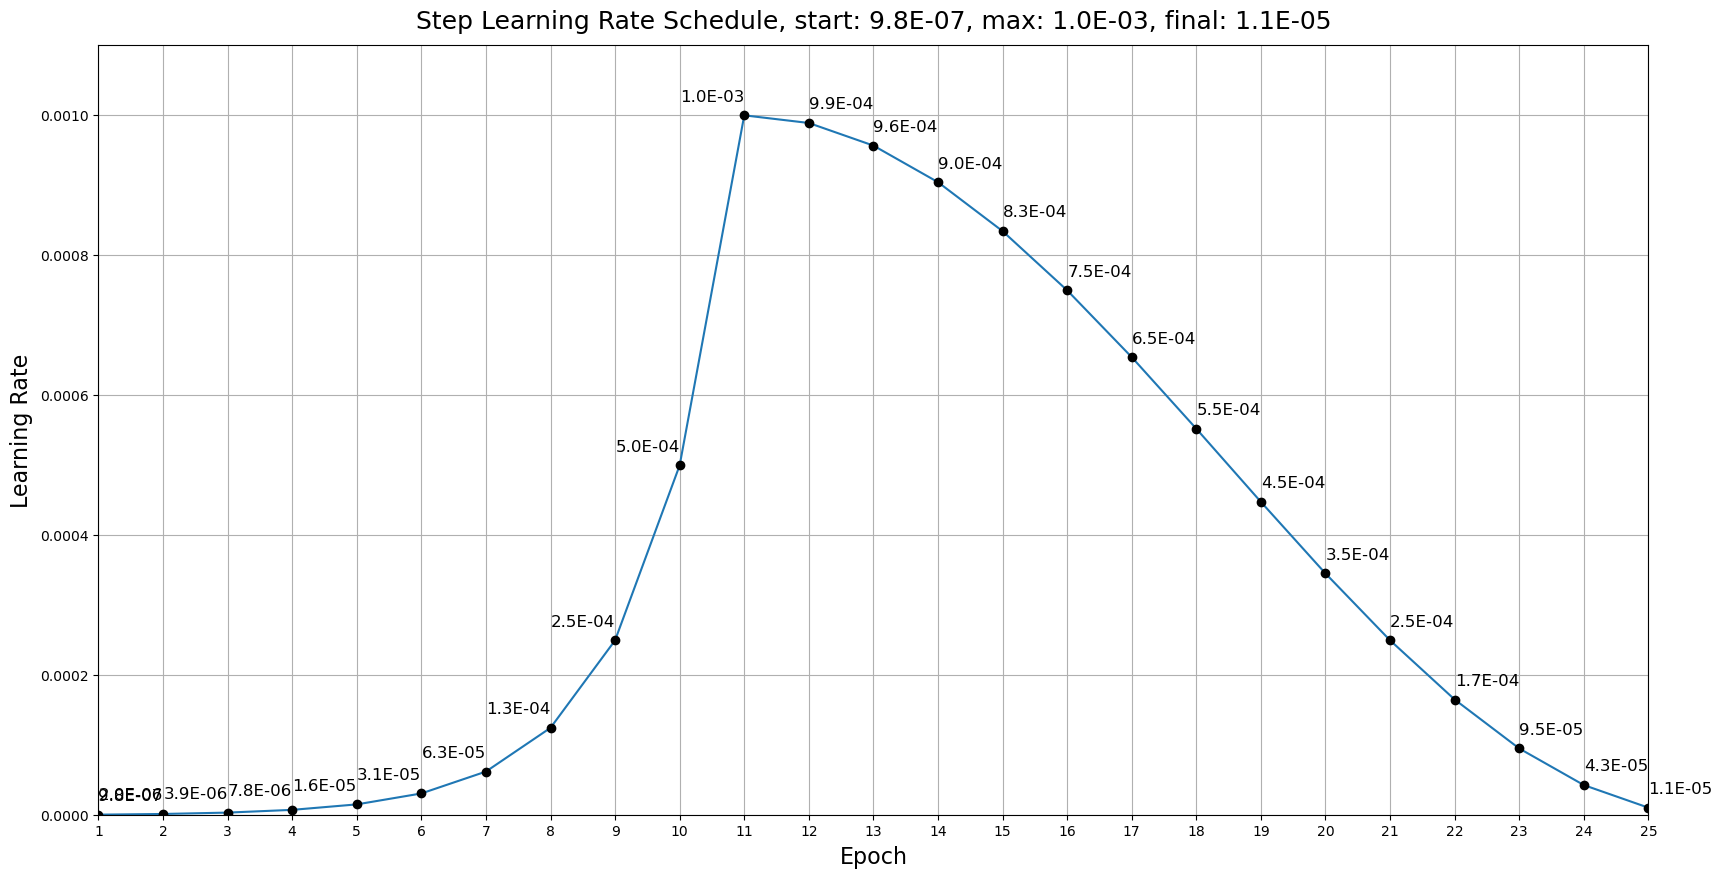

In [25]:
def lrfn(current_step, num_warmup_steps, lr_max, num_cycles=0.50, num_training_steps=N_EPOCHS):
    
    if current_step < num_warmup_steps:
        if WARMUP_METHOD == 'log':
            return lr_max * 0.10 ** (num_warmup_steps - current_step)
        else:
            return lr_max * 2 ** -(num_warmup_steps - current_step)
    else:
        progress = float(current_step - num_warmup_steps) / float(max(1, num_training_steps - num_warmup_steps))

        return max(0.0, 0.5 * (1.0 + math.cos(math.pi * float(num_cycles) * 2.0 * progress))) * lr_max
    
def plot_lr_schedule(lr_schedule, epochs):
    fig = plt.figure(figsize=(20, 10))
    plt.plot([None] + lr_schedule + [None])
    # X Labels
    x = np.arange(1, epochs + 1)
    x_axis_labels = [i if epochs <= 40 or i % 5 == 0 or i == 1 else None for i in range(1, epochs + 1)]
    plt.xlim([1, epochs])
    plt.xticks(x, x_axis_labels) # set tick step to 1 and let x axis start at 1
    
    # Increase y-limit for better readability
    plt.ylim([0, max(lr_schedule) * 1.1])
    
    # Title
    schedule_info = f'start: {lr_schedule[0]:.1E}, max: {max(lr_schedule):.1E}, final: {lr_schedule[-1]:.1E}'
    plt.title(f'Step Learning Rate Schedule, {schedule_info}', size=18, pad=12)
    
    # Plot Learning Rates
    for x, val in enumerate(lr_schedule):
        if epochs <= 40 or x % 5 == 0 or x is epochs - 1:
            if x < len(lr_schedule) - 1:
                if lr_schedule[x - 1] < val:
                    ha = 'right'
                else:
                    ha = 'left'
            elif x == 0:
                ha = 'right'
            else:
                ha = 'left'
            plt.plot(x + 1, val, 'o', color='black');
            offset_y = (max(lr_schedule) - min(lr_schedule)) * 0.02
            plt.annotate(f'{val:.1E}', xy=(x + 1, val + offset_y), size=12, ha=ha)
    
    plt.xlabel('Epoch', size=16, labelpad=5)
    plt.ylabel('Learning Rate', size=16, labelpad=5)
    plt.grid()
    plt.show()

# Learning rate for encoder
LR_SCHEDULE = [lrfn(step, num_warmup_steps=N_WARMUP_EPOCHS, lr_max=LR_MAX, num_cycles=0.50) for step in range(N_EPOCHS)]
# Plot Learning Rate Schedule
plot_lr_schedule(LR_SCHEDULE, epochs=N_EPOCHS)
# Learning Rate Callback
lr_callback = tf.keras.callbacks.LearningRateScheduler(lambda step: LR_SCHEDULE[step], verbose=0)

# Custom callback to update weight decay with learning rate
class WeightDecayCallback(tf.keras.callbacks.Callback):
    def __init__(self, wd_ratio=WD_RATIO):
        self.step_counter = 0
        self.wd_ratio = wd_ratio
    
    def on_epoch_begin(self, epoch, logs=None):
        model.optimizer.weight_decay = model.optimizer.learning_rate * self.wd_ratio
        print(f'learning rate: {model.optimizer.learning_rate.numpy():.2e}, weight decay: {model.optimizer.weight_decay.numpy():.2e}')

In [26]:
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=N_EPOCHS,
    callbacks=[
        validation_callback,
        lr_callback,
        WeightDecayCallback(),
    ]
)

learning rate: 9.77e-07, weight decay: 4.88e-08
Epoch 1/25
   1374/Unknown - 598s 390ms/step - loss: 592.5779----------------------------------------------------------------------------------------------------
Target    : 3 creekhouse^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: -63-67t6e6o7-a6e6e-e7-6-6u6e6e6e6, len: 33
----------------------------------------------------------------------------------------------------
Target    : scales/kuhaylah^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: 6vhe/ebheh0ehevevebeb9h, len: 23
----------------------------------------------------------------------------------------------------
Target    : 1383 william lanier^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: e9e9e -e-e79e7e-.-e9e-me-ememe, len: 30
----------------------------------------------------------------------------------------------------
Target    : 988 franklin lane^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: -e-e-, len: 5
-

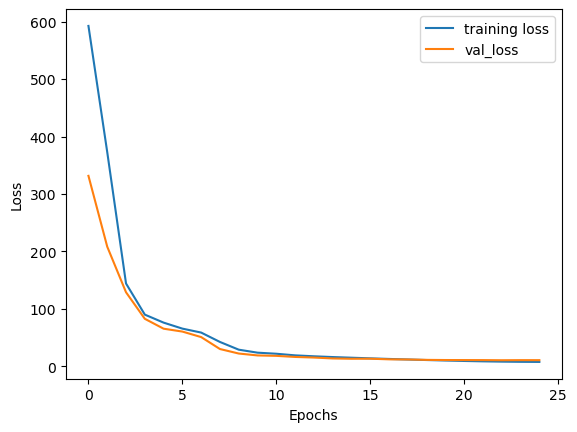

In [27]:
# GRAPHIC
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plotting the training and validation loss
plt.plot(train_loss, label='training loss')
plt.plot(val_loss, label='val_loss')

# Adding labels and legend
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Display the plot
plt.show()

In [28]:
class TFLiteModel(tf.Module):
    def __init__(self, model):
        super(TFLiteModel, self).__init__()
        self.model = model
    
    @tf.function(input_signature=[tf.TensorSpec(shape=[None, len(SEL_COLS)], dtype=tf.float32, name='inputs')])
    def __call__(self, inputs, training=False):
        # Preprocess Data
        x = tf.cast(inputs, tf.float32)
        x = x[None]
        x = tf.cond(tf.shape(x)[1] == 0, lambda: tf.zeros((1, 1, len(SEL_COLS))), lambda: tf.identity(x))
        x = x[0]
        x = pre_process0(x)
        x = pre_process1(*x)
        x = tf.reshape(x, INPUT_SHAPE)
        x = x[None]
        x = self.model(x, training=False)
        x = x[0]
        x = decode_phrase(x)
        x = tf.cond(tf.shape(x)[0] == 0, lambda: tf.zeros(1, tf.int64), lambda: tf.identity(x))
        x = tf.one_hot(x, 59)
        return {'outputs': x}

tflitemodel_base = TFLiteModel(model)
tflitemodel_base(frames)["outputs"].shape

TensorShape([13, 59])

In [29]:
keras_model_converter = tf.lite.TFLiteConverter.from_keras_model(tflitemodel_base)
keras_model_converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS]#, tf.lite.OpsSet.SELECT_TF_OPS]
keras_model_converter.optimizations = [tf.lite.Optimize.DEFAULT]
keras_model_converter.target_spec.supported_types = [tf.float16]
tflite_model = keras_model_converter.convert()
with open('model.tflite', 'wb') as f:
    f.write(tflite_model)
    
with open('inference_args.json', "w") as f:
    json.dump({"selected_columns" : SEL_COLS}, f)
    
!zip submission.zip  './model.tflite' './inference_args.json'

  adding: model.tflite (deflated 9%)
  adding: inference_args.json (deflated 83%)


In [30]:
with open ("inference_args.json", "r") as f:
    SEL_COLS = json.load(f)["selected_columns"]
    
def load_relevant_data_subset(pq_path):
    return pd.read_parquet(pq_path, columns=SEL_COLS)

def create_data_gen(file_ids, y_mul=1):
    def gen():
        for file_id in file_ids:
            pqfile = f"{inpdir}/{file_id}.parquet"
            seq_refs = df.loc[df.file_id == file_id]
            seqs = load_relevant_data_subset(pqfile)

            for seq_id in seq_refs.sequence_id:
                x = seqs.iloc[seqs.index == seq_id].to_numpy()
                y = str(df.loc[df.sequence_id == seq_id].phrase.iloc[0])
                
                r_nonan = np.sum(np.sum(np.isnan(x[:, RHAND_IDX_X]), axis = 1) == 0)
                l_nonan = np.sum(np.sum(np.isnan(x[:, LHAND_IDX_X]), axis = 1) == 0)
                no_nan = max(r_nonan, l_nonan)
                
                if y_mul*len(y)<no_nan:
                    yield x, y
    return gen

pqfiles = df.file_id.unique()
val_len = int(0.05 * len(pqfiles))

test_dataset = tf.data.Dataset.from_generator(create_data_gen(pqfiles[:val_len], 0),
    output_signature=(tf.TensorSpec(shape=(None, len(SEL_COLS)), dtype=tf.float32), tf.TensorSpec(shape=(), dtype=tf.string))
).prefetch(buffer_size=2000)

In [31]:
interpreter = tf.lite.Interpreter("model.tflite")

REQUIRED_SIGNATURE = "serving_default"
REQUIRED_OUTPUT = "outputs"

with open ("/kaggle/input/asl-fingerspelling/character_to_prediction_index.json", "r") as f:
    character_map = json.load(f)
rev_character_map = {j:i for i,j in character_map.items()}

prediction_fn = interpreter.get_signature_runner(REQUIRED_SIGNATURE)

for frame, target in test_dataset.skip(100).take(10):
    output = prediction_fn(inputs=frame)
    prediction_str = "".join([rev_character_map.get(s, "") for s in np.argmax(output[REQUIRED_OUTPUT], axis=1)])
    target = target.numpy().decode("utf-8")
    print("pred =", prediction_str, "; target =", target)

pred = 4874 sain ; target = 4874 sairley
pred = 52-5-20 ; target = 752-573-2075
pred = tby larson ; target = toby larson
pred = +878-34-43-656 ; target = +878-34-43-656
pred = +49-81-95228 ; target = +49-81-95228
pred = 3830 pr 3906th ; target = 3830 pn 3906th
pred = +3-34-6-7950 ; target = +31-103-4764-61-76950
pred = www.lemon.co.jp ; target = www.lemon.co.jp
pred = 7575 onawa drive ; target = 7575 onawa drive
pred = 199-896 ; target = 841-199-8196


In [32]:
%%timeit -n 10
output = prediction_fn(inputs=frame)

138 ms ± 894 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [33]:
from Levenshtein import distance

scores = []

for i, (frame, target) in tqdm(enumerate(test_dataset.take(1000))):
    output = prediction_fn(inputs=frame)
    prediction_str = "".join([rev_character_map.get(s, "") for s in np.argmax(output[REQUIRED_OUTPUT], axis=1)])
    target = target.numpy().decode("utf-8")
    score = (len(target) - distance(prediction_str, target)) / len(target)
    scores.append(score)
    if i % 50 == 0:
        print(np.sum(scores) / len(scores))
    
scores = np.array(scores)
print(np.sum(scores) / len(scores))

2it [00:00,  3.19it/s]

0.9166666666666666


52it [00:08,  7.03it/s]

0.7588858155331458


102it [00:15,  6.95it/s]

0.7271788019198072


152it [00:23,  6.99it/s]

0.7189857200612361


202it [00:30,  6.93it/s]

0.7126612621576933


252it [00:37,  6.86it/s]

0.6986407808583333


302it [00:45,  6.69it/s]

0.6897266821932638


352it [00:52,  7.06it/s]

0.6807323282630797


402it [00:59,  6.97it/s]

0.6775753596816588


452it [01:06,  6.98it/s]

0.6727338439455264


502it [01:13,  7.00it/s]

0.6790226746550817


552it [01:21,  6.95it/s]

0.6742700924400526


602it [01:28,  7.01it/s]

0.6822204057364558


652it [01:35,  7.02it/s]

0.6828098960211993


702it [01:42,  6.99it/s]

0.6775237204096639


752it [01:50,  6.98it/s]

0.6821356799008048


802it [01:57,  6.60it/s]

0.684492964075648


852it [02:04,  6.96it/s]

0.6844515163540665


902it [02:11,  7.04it/s]

0.6806884698465172


952it [02:19,  6.89it/s]

0.6818655264864236


1000it [02:26,  6.84it/s]


0.6809391442319709


In [4]:
from Levenshtein import distance

# Target and predicted phrases
pairs = [
    ("18 cutter ridge road", "18 cutter cridge road"),
    ("492288 west 28th terrace south", "492288 west 28th teracsou"),
    ("1121 east 2609th road", "1121 east 2609th road")
]

scores = []

for target, prediction in pairs:
    score = (len(target) - distance(prediction, target)) / len(target)
    scores.append(score)

# Calculate average score
average_score = sum(scores) / len(scores)
print(f"Levenshtein Distance Average Score: {average_score}")


Levenshtein Distance Average Score: 0.9277777777777777
